<a href="https://colab.research.google.com/github/Cipe96/EEG-Recognition/blob/main/Classificatore_EEGNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size=6>**EEG Recognition: Classificatore Convolutivo**</font>
</br><font size=3>*Marco Cipollina, Riccardo Era*</font>


<p style="font-size:4px;" align="justify">In questo notebook viene testata l'efficienza del modello convolutivo EEGNet, sul uale si possono trovare ulteriori informazioni al seguente <a href="https://arxiv.org/abs/1611.08024">link</a>.</p>
<p style="font-size:4px;" align="justify">Abbiamo replicato il notebook del nostro convolutivo al fine di adattarlo al nuovo classificatore.</p>

<font size=4>**Indice:**</font>
*   [Import librerie](#1)
*   [Downloads](#2)
*   [Classificatore EEGnet](#3)

<a name="1"></a>
# **Import librerie**

Importiamo le librerie e montiamo Google Drive per garantire l'accesso agli altri file.

In [ ]:
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
import pandas as pd
import numpy as np
import sys
import os

SEED = 96                                                                       #Impostiamo un seme specifico per garantire la replicabilità degli esperimenti

In [ ]:
%%capture
drive.mount('/content/drive', force_remount=True)

# elimina la cartella sample_data creata automaticamente
! rm -r /content/sample_data

In [ ]:
#@title Percorso della cartella del progetto su Google Drive:

#@markdown Se la cartella del progetto si trova nella root di Drive, scrivere solo il suo nome:

PERCORSO_DRIVE = "EEG Recognition" #@param {type:"string"}

PERCORSO_DRIVE = '/content/drive/MyDrive/' + PERCORSO_DRIVE

In [ ]:
sys.path.append(PERCORSO_DRIVE)                                                 # ci permetterà di importare le funzioni presenti in altri file
from EEGModels import EEGNet                                                    # importare il classificatore convolutivo

<a name="2"></a>
# **Download**

In [ ]:
#@title Seleziona la Run che vuoi utilizzare (fra quelle che hai sul drive):

#@markdown Inserisci un valore compreso fra 1 e 14 inclusi:

run = 6 #@param {type:"integer"}
run = f"R{run:02d}"


In [ ]:
#@title Seleziona la banda che vuoi utilizzare:

#@markdown (delta, theta, alpha, beta, gamma, broadband, personalizzata, ABG)

banda = 'ABG' #@param ['delta', 'theta', 'alpha', 'beta', 'gamma', 'broadband', 'personalizzata', 'ABG']
save_path = f'{PERCORSO_DRIVE}/Dati preprocessati/{run}/{banda}'

In [ ]:
#@title Carica i dati
train_data = np.load(f"{save_path}/train_data_{banda}.npy")
train_labels = np.load(f"{save_path}/train_labels_{banda}.npy")
val_data = np.load(f"{save_path}/val_data_{banda}.npy")
val_labels = np.load(f"{save_path}/val_labels_{banda}.npy")
test_data = np.load(f"{save_path}/test_data_{banda}.npy")
test_labels = np.load(f"{save_path}/test_labels_{banda}.npy")

Controlliamo che la shape sia coerente con quella che ci servirà per il modello di classificazione. Nel caso di EEGNet viene utilizzata la convenzione First Channel

In [ ]:
#EEGNet sfrutta la shape channelsFirst
train_data = np.transpose(train_data, (0, 2, 1))
val_data = np.transpose(val_data, (0, 2, 1))
test_data = np.transpose(test_data, (0, 2, 1))
# Verifica le dimensioni dei dataset e delle etichette
print(f"Train set shape: {train_data.shape}, Train labels shape: {train_labels.shape}")
print(f"Validation set shape: {val_data.shape}, Validation labels shape: {val_labels.shape}")
print(f"Test set shape: {test_data.shape}, Test labels shape: {test_labels.shape}")

Train set shape: (6235, 64, 240), Train labels shape: (6235,)
Validation set shape: (1308, 64, 240), Validation labels shape: (1308,)
Test set shape: (1417, 64, 240), Test labels shape: (1417,)


Effettuiamo uno shuffle del dataset per evitare di dare in pasto i dati al modello in maniera ordinata, permettendo così un addestramento meno condizionato.

In [ ]:
# shuffle dei dataset e ettichette con stesso ordine di shuffle
train_data, train_labels = shuffle(train_data, train_labels, random_state=SEED)
val_data, val_labels = shuffle(val_data, val_labels, random_state=SEED)
test_data, test_labels = shuffle(test_data, test_labels, random_state=SEED)


In [ ]:
# Riprendiamo il numero di classi esistenti
num_classes = len(np.unique(train_labels))
print("Numero di classi:", num_classes)

# Convertiamo le etichette in one-hot encoding
y_train = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(val_labels, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(test_labels, num_classes=num_classes)


Numero di classi: 109


<a name="3"></a>
# **Classificatore EEGNet**

Costruiamo il nostro modello convoluzionale utilizzando alcune delle best practices (SeparableConv, DropOut, BatchNormalization) e uno strato Dense per permetterci di classificare i nostri volontari.

In [ ]:
model = EEGNet(nb_classes = 109, Chans = 64, Samples = 240)

# Compiliamo il modello
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Verifichiamo che il modello sia costruito come vogliamo.

In [ ]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 64, 240, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 240, 8)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 64, 240, 8)          │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ depthwise_conv2d_4 (DepthwiseConv2D) │ (None, 1, 240, 16)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 1, 240, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 1, 240, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_8                  │ (None, 1, 60, 16)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 1, 60, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 1, 60, 16)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 1, 60, 16)           │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 1, 60, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_9                  │ (None, 1, 7, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1, 7, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 109)                 │          12,317 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Activation)                 │ (None, 109)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,525 (56.74 KB)

 Trainable params: 14,445 (56.43 KB)

 Non-trainable params: 80 (320.00 B)

Creiamo una callback per salvare i pesi con i quali si otterranno i risultati migliori sul validation set e avviamo il training.

In [ ]:
#@title Addestramento con validazione
#Salviamo i pesi dell'epoca in cui abbiamo ottenuto il val_loss minore
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"best-{banda}-EEGNet.keras", save_best_only=True, monitor="val_loss"),
]

# Addestriamo il modello
history = model.fit(train_data, y_train, epochs=300, batch_size=32, validation_data=(val_data, y_val), callbacks=callback)


Epoch 1/300
195/195 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - accuracy: 0.0208 - loss: 4.5379 - val_accuracy: 0.0550 - val_loss: 4.2712
Epoch 2/300
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1198 - loss: 3.8621 - val_accuracy: 0.2676 - val_loss: 3.5569
Epoch 3/300
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2328 - loss: 3.5030 - val_accuracy: 0.3914 - val_loss: 3.2166
Epoch 4/300
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3073 - loss: 3.3129 - val_accuracy: 0.4404 - val_loss: 3.0675
Epoch 5/300
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3501 - loss: 3.1521 - val_accuracy: 0.5168 - val_loss: 2.9181
Epoch 6/300
195/195 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3931 - loss: 3.0281 - val_accuracy: 0.5084 - val_loss: 2.7709
Epoch 7/300
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4107 - loss: 2.9119 - val_accuracy: 0.5925 - val_loss: 2.6837
Epoch 8/300
195/195 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4414 - loss: 2.8259 - val_

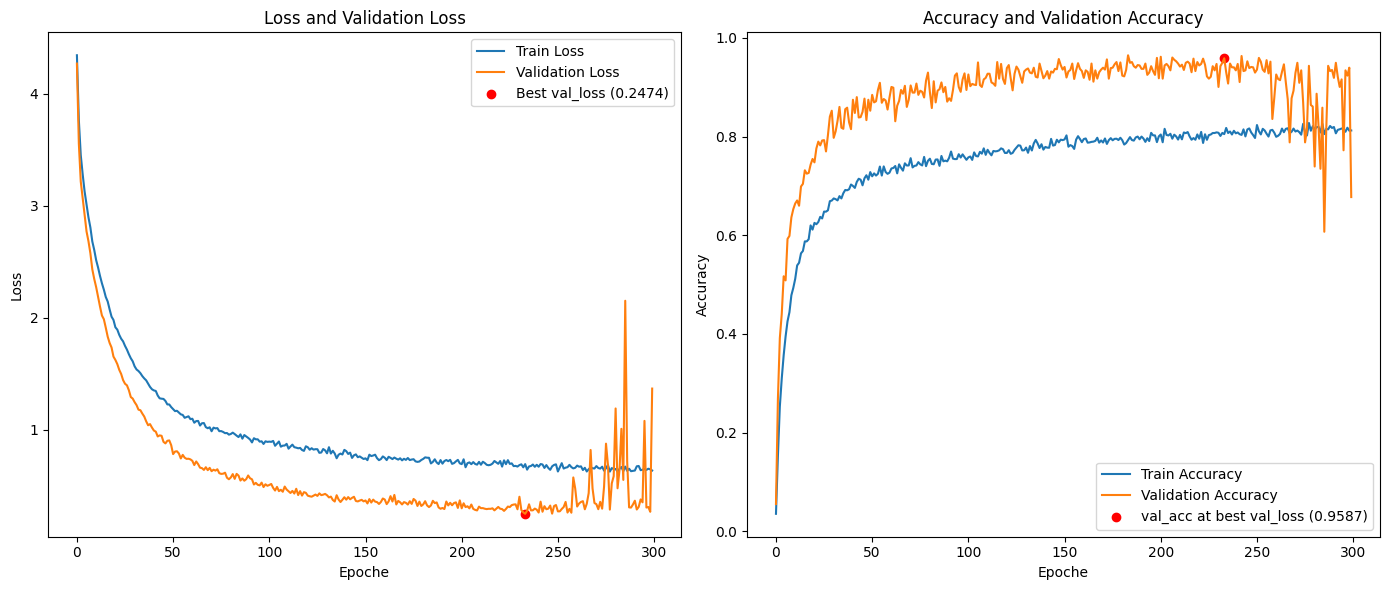

In [ ]:
#@title Grafico confronto fra Loss e Accuratezze
# Estrarre i dati dall'oggetto `history`
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', [])  # Alcuni modelli usano 'acc' invece di 'accuracy'
val_accuracy = history.history.get('val_accuracy', [])

# Individuare l'epoca con la miglior val_loss
best_epoch = np.argmin(val_loss)
best_val_loss = val_loss[best_epoch]

# Creare i grafici
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # Un grafico accanto all'altro

# Grafico Loss
axes[0].plot(loss, label="Train Loss")
axes[0].plot(val_loss, label="Validation Loss")
axes[0].scatter(best_epoch, best_val_loss, color='red', label=f"Best val_loss ({best_val_loss:.4f})")
axes[0].set_title("Loss and Validation Loss")
axes[0].set_xlabel("Epoche")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Grafico Accuracy
if accuracy and val_accuracy:
    axes[1].plot(accuracy, label="Train Accuracy")
    axes[1].plot(val_accuracy, label="Validation Accuracy")
    if val_accuracy:
        best_val_accuracy = val_accuracy[best_epoch]
        axes[1].scatter(best_epoch, best_val_accuracy, color='red', label=f"val_acc at best val_loss ({best_val_accuracy:.4f})")
    axes[1].set_title("Accuracy and Validation Accuracy")
    axes[1].set_xlabel("Epoche")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

# Mostrare i grafici
plt.tight_layout()
plt.show()


---
Questo classificatore ha necessità di un numero molto maggiore di epoche, nonostante la sua struttura più complessa.
Una volta convalidati gli iperparametri grazia al
validation set, sfruttiamo tutti i dati disponibili per l'addestramento del modello.

In [ ]:
#@title Uniamo e rimescoliamo trainset con validation set

# Uniamo i dati
combined_data = np.concatenate((train_data, val_data), axis=0)
combined_labels = np.concatenate((y_train, y_val), axis=0)

# Mescoliamo di nuovo
combined_data, combined_labels = shuffle(combined_data, combined_labels, random_state=SEED)

In [ ]:
#@title Addestramento finale
#Ricompiliamo il modello
model = EEGNet(nb_classes = 109, Chans = 64, Samples = 240)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#Salviamo i pesi dell'epoca in cui abbiamo ottenuto il val_loss minore
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath=f"best-{banda}-finale_EEGNet.keras", save_best_only=True, monitor="loss"),
]

# Addestriamo il modello
history = model.fit(combined_data, combined_labels, epochs=300, batch_size=32, callbacks=callback)


Epoch 1/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.0292 - loss: 4.4865
Epoch 2/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1292 - loss: 3.7700
Epoch 3/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2690 - loss: 3.3867
Epoch 4/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.3798 - loss: 3.1391
Epoch 5/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4304 - loss: 2.9603
Epoch 6/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4784 - loss: 2.7999
Epoch 7/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4974 - loss: 2.6898
Epoch 8/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5210 - loss: 2.5919
Epoch 9/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5275 - loss: 2.5106
Epoch 10/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5416 - loss: 2.4063
Epoch 11/300
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5625 - loss: 2.3202
Epoch 12/300
236/236 ━━━━━━━━━━━━━━━━━━

Per ricaricare i pesi che hanno performato meglio durante l'addestramento:

In [ ]:
model = tf.keras.models.load_model(f"best-{banda}-finale_EEGNet.keras")

In [ ]:
#@title Se vuoi salvare o caricare il modello (architettura, pesi e configurazioni), seleziona il percorso qui:

weights_path = f'{PERCORSO_DRIVE}/Dati preprocessati/{run}/Pesi convolutivo/'
salvare_caricare = 'salvare' #@param ['salvare', 'caricare']
nome_file = 'best-ABG-finale_EEGNet.keras' #@param {type:"string"}
# Verifica se la cartella esiste già
if not os.path.exists(weights_path):
  os.makedirs(weights_path)                                                     # Crea la cartella
  print(f"Cartella '{weights_path}' creata con successo.")

if salvare_caricare == 'salvare':
  model.save(weights_path + nome_file)
  print("architettura, pesi e configurazione salvati con successo")

elif salvare_caricare == 'caricare':
  model = tf.keras.models.load_model(weights_path + nome_file)
  print("architettura, pesi e configurazione caricati con successo")


architettura, pesi e configurazione salvati con successo


Valutiamo infine le prestazioni del modello sul test set.

In [ ]:
loss, accuracy = model.evaluate(test_data, y_test, verbose=0)
print(f'Accuratezza sul test: {accuracy:.4f}')

Accuratezza sul test: 0.9548
